# MGMT298D: Science and Strategy of AI
# **Week 1 - Linear Regression with Feature Engineering**

**Instructor:** Professor Siddiq  
**Student:** _Your Name Here_

In [49]:
# ---------------------------------------------------------
# 1. Imports and Helper Functions
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


MONTHS = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]

def report_metrics(y_true, y_pred, label=""):
    """Print R², RMSE, and MAE for easy comparison."""
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label}R²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")

def show_top_coeffs(model, feature_names, k=12):
    """Show the k largest coefficients in absolute value."""
    coefs = pd.Series(model.coef_, index=feature_names)
    top = coefs.abs().sort_values(ascending=False).head(k)
    print("\n[Top features by |coefficient|]")
    print(top)

def visualize_lasso_cv(model, model_name="LASSO"):
    """Plot CV error vs alpha and print sparsity info."""
    if not hasattr(model, "alphas_") or not hasattr(model, "mse_path_"):
        print(f"[WARN] {model_name}: no CV path available.")
        return

    mean_mse = np.mean(model.mse_path_, axis=1)
    std_mse = np.std(model.mse_path_, axis=1)

    plt.figure(figsize=(6, 4))
    plt.semilogx(model.alphas_, mean_mse)
    plt.fill_between(model.alphas_, mean_mse - std_mse, mean_mse + std_mse, alpha=0.2)
    plt.axvline(model.alpha_, linestyle="--")
    plt.xlabel("Alpha (penalty)")
    plt.ylabel("Cross-validated MSE")
    plt.title(f"{model_name}: CV Error vs Alpha")
    plt.show()

    n_nonzero = np.sum(model.coef_ != 0)
    print(f"[INFO] {model_name} selected alpha = {model.alpha_:.4g}")
    print(f"[INFO] Nonzero coefficients: {n_nonzero} / {len(model.coef_)}")


## 2A. Product Types Available

Below is the full list of product types found in the dataset.Please **choose one** and assign it to `PRODUCT_NAME` in the code cell below (e.g., `"Hoodie"` or `"Dress"`).

*Alice band, Baby Bib, Backpack, Bag, Ballerinas, Beanie, Belt, Bikini top, Blanket, Blazer, Blouse, Bodysuit, Bootie, Boots, Bra, Bra extender, Bracelet, Braces, Bucket hat, Cap, Cap/peaked, Cardigan, Chem. cosmetics, Coat, Costumes, Cushion, Dog Wear, Dress, Dungarees, Earring, Earrings, Felt hat, Fine cosmetics, Flat shoe, Flat shoes, Flip flop, Garment Set, Giftbox, Gloves, Hair clip, Hair string, Hair/alice band, Hairband, Hat/beanie, Hat/brim, Heels, Hoodie, Jacket, Jumpsuit/Playsuit, Keychain, Kids Underwear top, Leg warmers, Leggings/Tights, Long John, Necklace, Night gown, Nipple covers, Other accessories, Other shoe, Outdoor overall, Outdoor trousers, Outdoor Waistcoat, Polo shirt, Pumps, Pyjama bottom, Pyjama jumpsuit/playsuit, Pyjama set, Ring, Robe, Sandals, Sarong, Scarf, Sewing kit, Shirt, Shorts, Shoulder bag, Side table, Skirt, Sleep Bag, Sleeping sack, Slippers, Sneakers, Socks, Soft Toys, Straw hat, Sunglasses, Sweater, Swimsuit, Swimwear bottom, Swimwear set, Swimwear top, T-shirt, Tailored Waistcoat, Tie, Top, Tote bag, Trousers, Umbrella, Underdress, Underwear body, Underwear bottom, Underwear corset, Underwear set, Underwear Tights, Unknown, Vest top, Wallet, Watch, Waterbottle, Wedge, Weekend/Gym bag, Wood balls.*

In [50]:
# ---------------------------------------------------------
# 2. Load and basic cleaning
# ---------------------------------------------------------
CSV_PATH = "https://raw.githubusercontent.com/ucla-anderson-SSAI/SSAI/main/HMData.csv"

df = pd.read_csv(CSV_PATH)

# Focus on a single product category  see list above
PRODUCT_NAME = "Dress"
df = df[df["name"] == PRODUCT_NAME].copy()


In [51]:
# ---------------------------------------------------------
# 3. Create Training and Testing Data Sets
# ---------------------------------------------------------
Q4_MONTHS = ["October", "November", "December"]
unique_ids = df["id"].unique()

## Build training dataset
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2)
train_df = df[df["id"].isin(train_ids)].copy()

# Build test dataset
is_test_id = df["id"].isin(test_ids)
q4_cols = [c for c in ["October", "November", "December"] if c in df.columns]
is_q4 = df[q4_cols].any(axis=1)   # True if any of those month dummies == 1
test_df = df[is_test_id & is_q4].copy()



## 4. Baseline LASSO

We drop obvious non-features (`id`, `name`, `demand`) and keep everything else. Then we scale and fit `LassoCV`.


[Baseline LASSO] R²=0.039, RMSE=85.26, MAE=45.23

[Top features by |coefficient|]
Baby/Children     8.784657
Dresses Ladies    5.390344
June              4.996181
Black             4.144015
July              2.890323
Dot               2.628472
Jersey Basic      2.170432
April             1.716256
Blouses           1.603105
Dark Green        1.508680
price             1.155515
May               1.066619
dtype: float64


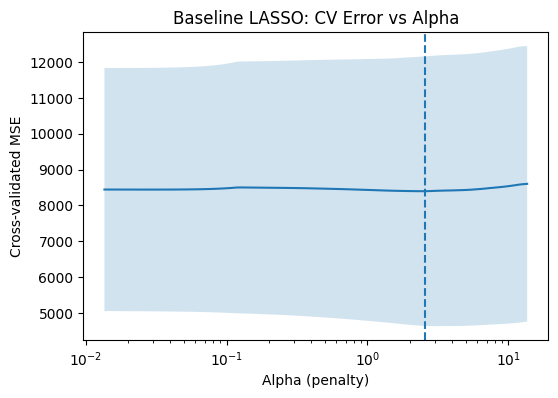

[INFO] Baseline LASSO selected alpha = 2.547
[INFO] Nonzero coefficients: 15 / 115


In [52]:
# ---------------------------------------------------------
# 4. Baseline LASSO
# ---------------------------------------------------------
drop_cols = ["id", "name", "demand"]

X_train_base = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
X_train_base = X_train_base.apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_base = train_df["demand"].astype(float)

X_test_base = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])
X_test_base = X_test_base.apply(pd.to_numeric, errors="coerce").fillna(0)
y_test_base = test_df["demand"].astype(float)

scaler_base = StandardScaler(with_mean=False)
Xtr_base = scaler_base.fit_transform(X_train_base)
Xte_base = scaler_base.transform(X_test_base)

lasso_base = LassoCV()
lasso_base.fit(Xtr_base, y_train_base)
y_pred_base = lasso_base.predict(Xte_base)

report_metrics(y_test_base, y_pred_base, label="[Baseline LASSO] ")
show_top_coeffs(lasso_base, X_train_base.columns, k=12)

visualize_lasso_cv(lasso_base, "Baseline LASSO")


## 5. (Optional) Light time-style features

If the file ever has multiple months per `id`, this shows how to make lag-style features. With one row per `id`, they will just be 0 — still fine for teaching.


[FE LASSO] R²=0.326, RMSE=71.39, MAE=33.52

[Top features by |coefficient|]
lag_demand_1      40.250328
price_change       5.363083
Baby/Children      5.004847
June               3.509083
Dresses Ladies     3.076303
April              2.997476
Black              2.795619
August             2.568583
Dot                1.314202
Jersey Basic       1.228340
Dark Green         0.999435
December           0.983840
dtype: float64


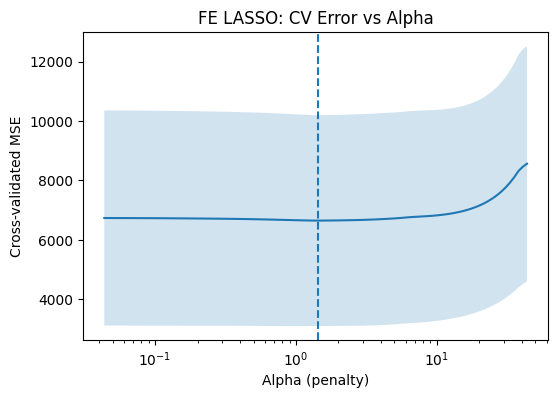

[INFO] FE LASSO selected alpha = 1.428
[INFO] Nonzero coefficients: 22 / 118


In [53]:
# ---------------------------------------------------------
# 5. Feature-engineered version (lags, MA, price change)
# ---------------------------------------------------------
df_fe = df.copy()

def infer_month_num(row):
    for i, m in enumerate(MONTHS, start=1):
        if m in row and row[m] == 1:
            return i
    return np.nan

df_fe["month_num"] = df_fe.apply(infer_month_num, axis=1)
df_fe = df_fe.sort_values(["id", "month_num"]).reset_index(drop=True)

# Create simple time features per id
df_fe["lag_demand_1"] = df_fe.groupby("id")["demand"].shift(1)
df_fe["ma3_demand"] = (
    df_fe.groupby("id")["demand"].shift(1).rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
)
df_fe["price_change"] = df_fe.groupby("id")["price"].pct_change()
df_fe[["lag_demand_1", "ma3_demand", "price_change"]] = df_fe[["lag_demand_1", "ma3_demand", "price_change"]].fillna(0)

# Rebuild train/test on FE frame
train_fe = df_fe[df_fe["id"].isin(train_ids)].copy()
test_fe = df_fe[
    df_fe["id"].isin(test_ids)
    & (
        ((df_fe["October"] == 1) if "October" in df_fe.columns else False)
        | ((df_fe["November"] == 1) if "November" in df_fe.columns else False)
        | ((df_fe["December"] == 1) if "December" in df_fe.columns else False)
    )
].copy()

drop_cols_fe = ["id", "name", "demand", "month_num"]
X_train_fe = train_fe.drop(columns=[c for c in drop_cols_fe if c in train_fe.columns])
X_train_fe = X_train_fe.apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_fe = train_fe["demand"].astype(float)

X_test_fe = test_fe.drop(columns=[c for c in drop_cols_fe if c in test_fe.columns])
X_test_fe = X_test_fe.apply(pd.to_numeric, errors="coerce").fillna(0)
y_test_fe = test_fe["demand"].astype(float)

scaler_fe = StandardScaler(with_mean=False)
Xtr_fe = scaler_fe.fit_transform(X_train_fe)
Xte_fe = scaler_fe.transform(X_test_fe)

lasso_fe = LassoCV()
lasso_fe.fit(Xtr_fe, y_train_fe)
y_pred_fe = lasso_fe.predict(Xte_fe)

report_metrics(y_test_fe, y_pred_fe, label="[FE LASSO] ")
show_top_coeffs(lasso_fe, X_train_fe.columns, k=12)

visualize_lasso_cv(lasso_fe, "FE LASSO")


## 6. Questions and Reflections

1. **Question:** In the baseline model, which variables had the largest coefficients, and do they make sense for retail demand?
   **Response:**

2. **Question:** Why is splitting by SKU (`id`) a better test of generalization than a random row-wise split here?
   **Response:**

3. **Question:** If we had more months per SKU, what other time-based features would you add?
   **Response:**
